Version 1.1.0

# Mean encodings

In this programming assignment you will be working with `1C` dataset from the final competition. You are asked to encode `item_id` in 4 different ways:

    1) Via KFold scheme;  
    2) Via Leave-one-out scheme;
    3) Via smoothing scheme;
    4) Via expanding mean scheme.

**You will need to submit** the correlation coefficient between resulting encoding and target variable up to 4 decimal places.

### General tips

* Fill NANs in the encoding with `0.3343`.
* Some encoding schemes depend on sorting order, so in order to avoid confusion, please use the following code snippet to construct the data frame. This snippet also implements mean encoding without regularization.

In [11]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

# Read data

In [2]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')

In [6]:
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

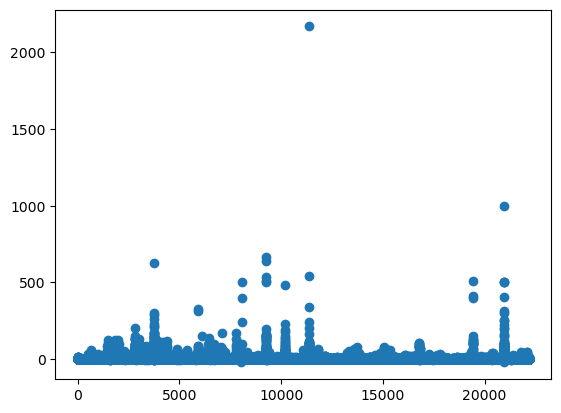

In [15]:
plt.scatter(sales.item_id, sales.item_cnt_day)

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [36]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Your existing code for creating the grid
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(cur_shops, cur_items, [block_num])), dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

# Aggregation without nested renamer
gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day': 'sum'})

# Renaming the column after aggregation
gb.rename(columns={'item_cnt_day': 'target'}, inplace=True)

# Joining aggregated data to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Sorting the data
all_data.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [18]:
all_data.head()

shop_id  item_id  date_block_num  target
139255        0       19               0     0.0
141495        0       27               0     0.0
144968        0       28               0     0.0
142661        0       29               0     0.0
138947        0       32               0     6.0

# Mean encodings without regularization

After we did the techinical work, we are ready to actually *mean encode* the desired `item_id` variable. 

Here are two ways to implement mean encoding features *without* any regularization. You can use this code as a starting point to implement regularized techniques. 

#### Method 1

In [19]:
# Calculate a mapping: {item_id: target_mean}
item_id_target_mean = all_data.groupby('item_id').target.mean()

# In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data['item_target_enc'] = all_data['item_id'].map(item_id_target_mean)

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.4830386988621764


#### Method 2

In [20]:
'''
     Differently to `.target.mean()` function `transform` 
   will return a dataframe with an index like in `all_data`.
   Basically this single line of code is equivalent to the first two lines from of Method 1.
'''
all_data['item_target_enc'] = all_data.groupby('item_id')['target'].transform('mean')

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.4830386988621764


See the printed value? It is the correlation coefficient between the target variable and your new encoded feature. You need to **compute correlation coefficient** between the encodings, that you will implement and **submit those to coursera**.

# 1. KFold scheme

Explained starting at 41 sec of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

**Now it's your turn to write the code!** 

You may use 'Regularization' video as a reference for all further tasks.

First, implement KFold scheme with five folds. Use KFold(5) from sklearn.model_selection. 

1. Split your data in 5 folds with `sklearn.model_selection.KFold` with `shuffle=False` argument.
2. Iterate through folds: use all but the current fold to calculate mean target for each level `item_id`, and  fill the current fold.

    *  See the **Method 1** from the example implementation. In particular learn what `map` and pd.Series.map functions do. They are pretty handy in many situations.

<h3>Solution</h3>

In [30]:
from sklearn.model_selection import KFold
k_fold = all_data.copy()

kf = KFold(n_splits=5, shuffle=False)
encoded_item_id = pd.Series(index=k_fold.index, dtype=float)

for train_index, test_index in kf.split(k_fold):
    train, test = k_fold.iloc[train_index], k_fold.iloc[test_index]

    mean_encoded = train.groupby('item_id')['target'].mean()

    encoded_item_id.iloc[test_index] = test['item_id'].map(mean_encoded)
    
k_fold['item_target_enc'] = encoded_item_id
k_fold['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = k_fold['item_target_enc'].values

In [35]:
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.41645907127988446


# 2. Leave-one-out scheme

Now, implement leave-one-out scheme. Note that if you just simply set the number of folds to the number of samples and run the code from the **KFold scheme**, you will probably wait for a very long time. 

To implement a faster version, note, that to calculate mean target value using all the objects but one *given object*, you can:

1. Calculate sum of the target values using all the objects.
2. Then subtract the target of the *given object* and divide the resulting value by `n_objects - 1`. 

Note that you do not need to perform `1.` for every object. And `2.` can be implemented without any `for` loop.

It is the most convenient to use `.transform` function as in **Method 2**.

<h3>Solution</h3>

In [46]:
leave_one = all_data.copy()

leave_one['item_target_sum'] = leave_one.groupby('item_id')['target'].transform('sum')
leave_one['item_count'] = leave_one.groupby('item_id')['target'].transform('count')
leave_one['item_target_enc'] = (leave_one['item_target_sum'] - leave_one['target']) / (leave_one['item_count'] - 1)
leave_one['item_target_enc'].fillna(0.3343, inplace=True)
encoded_feature = leave_one['item_target_enc'].values

In [52]:
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.4803848311293092


# 3. Smoothing

Explained starting at 4:03 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Next, implement smoothing scheme with $\alpha = 100$. Use the formula from the first slide in the video and $0.3343$ as `globalmean`. Note that `nrows` is the number of objects that belong to a certain category (not the number of rows in the dataset).

In [54]:
smoothing = all_data.copy()
alpha = 100
global_mean = 0.3343

smoothing['item_target_mean'] = smoothing.groupby('item_id')['target'].transform('mean')
smoothing['item_count'] = smoothing.groupby('item_id')['target'].transform('count')
smoothing['item_target_enc'] = (smoothing['item_target_mean'] * smoothing['item_count'] + global_mean * alpha) / (smoothing['item_count'] + alpha)
encoded_feature = smoothing['item_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.48181987970972573


# 4. Expanding mean scheme

Explained starting at 5:50 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Finally, implement the *expanding mean* scheme. It is basically already implemented for you in the video, but you can challenge yourself and try to implement it yourself. You will need [`cumsum`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.cumsum.html) and [`cumcount`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.GroupBy.cumcount.html) functions from pandas.

<h3>Solution</h3>

In [59]:
exp_mean = all_data.copy()

exp_mean['item_target_cumsum'] = exp_mean.groupby('item_id')['target'].transform('cumsum')
exp_mean['item_cumcount'] = exp_mean.groupby('item_id')['target'].transform('cumcount') + 1
exp_mean['item_target_enc'] = exp_mean['item_target_cumsum'] / exp_mean['item_cumcount']
exp_mean['item_target_enc'].fillna(0.3343, inplace=True)
encoded_feature = exp_mean['item_target_enc'].values

In [60]:
exp_mean

shop_id  item_id  date_block_num  target  item_target_cumsum  \
139255          0       19               0     0.0                 0.0   
141495          0       27               0     0.0                 0.0   
144968          0       28               0     0.0                 0.0   
142661          0       29               0     0.0                 0.0   
138947          0       32               0     6.0                 6.0   
...           ...      ...             ...     ...                 ...   
10768834       59    22162              33     0.0               699.0   
10769024       59    22163              33     0.0                75.0   
10769690       59    22164              33     0.0               493.0   
10771216       59    22166              33     0.0               348.0   
10770511       59    22167              33     0.0              1320.0   

          item_cumcount  item_target_enc  
139255                1         0.000000  
141495                1         0.000000  
144968                1         0.000000  
142661                1         0.000000  
138947                1         6.000000  
...                 ...              ...  
10768834            449         1.556793  
10769024            129         0.581395  
10769690            399         1.235589  
10771216           1176         0.295918  
10770511           1221         1.081081  

[10913850 rows x 7 columns]

In [61]:
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.5150897935757983


Finally, an improvement!